My work at the time of this model was on a project looking at education outcomes for deaf and hard-of-hearing (DHH) children. The State of Colorado instituted universal newborn hearing screening (UNHS) in 1997 to identify children with hearing loss sooner so that remediation could begin sooner. Then those children should start schooling not already lagging behind their peers. The problem was that UNHS's efficacy had never been demonstrated. This project was meant to demonstrate that UNHS works.

This model was a part of my capstone project at DU. The requirement for the capstone was to implement a machine learning model. Because the data (potentially) contained yearly reading scores for DHH children, my advisor suggested a long short-term memory (LSTM) model to capitalize on the time series component. However, the data were so sparse with so many missing values that we settled on using a reading score from one grade to predict the reading score in the next grade. We also included a number of demographic variables as predictors.

Demographic Variables:
    
Child grade

Home language (English vs. Spanish)

Degree of hearing loss (mild/moderate vs. severe/profound/cochlear implant)

Laterality of hearing loss (unilateral vs. bilateral)

Presence/absence of other disabilities

Participation in gifted/talented program

Participation in free/reduced lunch program (as a measure of socio-economic status)
     
Participation in Special Education

Participation in Section 504 (intermediate program between mainstreaming and special education)


In [1]:
import pandas as pd
import numpy as np
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [2]:
import matplotlib.pyplot as plt
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline

In [3]:
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


The original test score file contained all test results for all deaf
and hard-of-hearing children in the Denver Public Schools between 2000-
2017.

That file contained 289,456 rows and 14 columns, organized so that each 
row contained a single test score. Each child had multiple test scores, 
and so multiple rows, marked by child ID number, child grade, and test. 

This file was cleaned up to only include CSAP Reading scores and then
merged with a separate Demographics file. It was further organized such
that consecutive years were represented. That is, demographic information
and Grade 4 reading scores were used to predict Grade 5 reading scores.

The file loaded here, DataLinkageML.csv, is the end result of that 
clean-up process.


In [4]:
df = pd.read_csv('DataLinkageML.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()


,StudentNumber,DPS_HomeLg,CYI_Lat,CYI_Deg,Disability,GT_C,FRL_C,Sect504_C,SPED_C,t_grade,time_t,time_t1
0,405587,1.0000,1.0000,1.0000,0.0000,0.0000,1.0000,0.1000,0.8000,4,414,220
1,405587,1.0000,1.0000,1.0000,0.0000,0.0000,1.0000,0.1000,0.8000,5,220,260
2,405587,1.0000,1.0000,1.0000,0.0000,0.0000,1.0000,0.1000,0.8000,6,260,503
3,405587,1.0000,1.0000,1.0000,0.0000,0.0000,1.0000,0.1000,0.8000,7,503,537
4,405587,1.0000,1.0000,1.0000,0.0000,0.0000,1.0000,0.1000,0.8000,8,537,559


In [5]:
# train-test split

X = df.drop('time_t1', axis=1)
y = df['time_t1']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25)
X_train.shape, y_train.shape, X_test.shape, y_test.shape


((624, 11), (624,), (209, 11), (209,))

In [6]:
# Scale & transform X_train values

X_train_ts = X_train.values
#dataset = np.reshape(dataset, (-1, 1))
X_scaler = MinMaxScaler(feature_range=(0, 1))
X_train_ts = X_scaler.fit_transform(X_train_ts)


In [7]:
X_train_ts.shape


(624, 11)

In [8]:
# model expects shape (num_samples, num_timesteps, num_features)

X_train_ts = np.reshape(X_train_ts, (X_train_ts.shape[0],1,X_train_ts.shape[1]))
X_train_ts.shape


(624, 1, 11)

In [9]:
y_train.dtype

dtype('int64')

In [10]:
y_train = y_train.astype('float')

In [11]:
y_train_ts = y_train.values
y_train_ts = np.reshape(y_train_ts, (-1,1))
y_scaler = MinMaxScaler(feature_range=(0,1))
y_train_ts = y_scaler.fit_transform(y_train_ts)


In [12]:
y_train_ts.shape

(624, 1)

In [13]:
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(X_train_ts.shape[1], X_train_ts.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(256))
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train_ts, y_train_ts, epochs=50, batch_size=60, validation_split=.1, 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 561 samples, validate on 63 samples
Epoch 1/50
561/561 [==============================] - 3s 5ms/step - loss: 0.2796 - val_loss: 0.0926
Epoch 2/50
561/561 [==============================] - 0s 764us/step - loss: 0.0554 - val_loss: 0.0604
Epoch 3/50
561/561 [==============================] - 0s 867us/step - loss: 0.0373 - val_loss: 0.0347
Epoch 4/50
561/561 [==============================] - 0s 771us/step - loss: 0.0271 - val_loss: 0.0198
Epoch 5/50
561/561 [==============================] - 0s 833us/step - loss: 0.0193 - val_loss: 0.0178
Epoch 6/50
561/561 [==============================] - 0s 813us/step - loss: 0.0164 - val_loss: 0.0168
Epoch 7/50
561/561 [==============================] - 0s 824us/step - loss: 0.0154 - val_loss: 0.0155
Epoch 8/

In [14]:
# scale X_test and y_test using appropriate scalers
#X_test_ts = np.reshape(X_test_ts, (X_test_ts.shape[0],1,X_test_ts.shape[1]))
X_test_ts = X_scaler.transform(X_test)
X_test_ts = np.reshape(X_test_ts, (X_test_ts.shape[0],1,X_test_ts.shape[1]))

y_test_ts = y_test.values
y_test_ts = np.reshape(y_test_ts, (-1,1))
y_test_ts = y_scaler.transform(y_test_ts)

X_test_ts.shape, y_test_ts.shape

((209, 1, 11), (209, 1))

In [15]:
X_train_ts.shape, y_train_ts.shape, X_test_ts.shape, y_test_ts.shape

((624, 1, 11), (624, 1), (209, 1, 11), (209, 1))

In [16]:
train_predict = model.predict(X_train_ts)
test_predict = model.predict(X_test_ts)
#print(train_predict.shape, test_predict.shape)

# invert predictions
train_predict = y_scaler.inverse_transform(train_predict)
y_train_re = y_scaler.inverse_transform(y_train_ts)
test_predict = y_scaler.inverse_transform(test_predict)
y_test_re = y_scaler.inverse_transform(y_test_ts)
print(train_predict.shape,y_train_re.shape,test_predict.shape,y_test_re.shape)

print('Train Mean Absolute Error:', mean_absolute_error(y_train_re, train_predict))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train_re, train_predict)))
print('Test Mean Absolute Error:', mean_absolute_error(y_test_re, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test_re, test_predict)))



(624, 1) (624, 1) (209, 1) (209, 1)
Train Mean Absolute Error: 34.843897477174416
Train Root Mean Squared Error: 52.03116522772254
Test Mean Absolute Error: 34.81385985744056
Test Root Mean Squared Error: 46.54548911212465


In [17]:
print('Train R^2: ', r2_score(y_train_re, train_predict))
print('Test R^2: ', r2_score(y_test_re, test_predict))

Train R^2:  0.7030016822914715
Test R^2:  0.7703718163495995


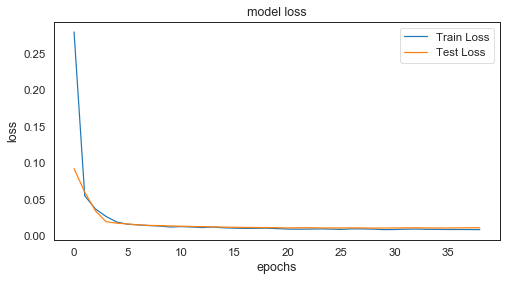

In [18]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

Text(0.5, 1.0, 'Train: True vs. Predicted')

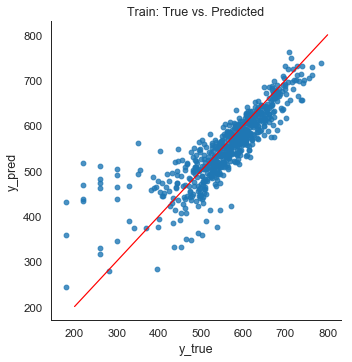

In [19]:
train_acc = pd.DataFrame()
train_acc['y_true'] = y_train_re[:,0]
train_acc['y_pred'] = train_predict[:,0]

x = np.linspace(200,800,1000)
ax = sns.lmplot(x='y_true', y='y_pred', data=train_acc, fit_reg=False)
ax = sns.lineplot(x=x,y=x, color='red')
plt.title('Train: True vs. Predicted')

Text(0.5, 1.0, 'Test: True vs. Predicted')

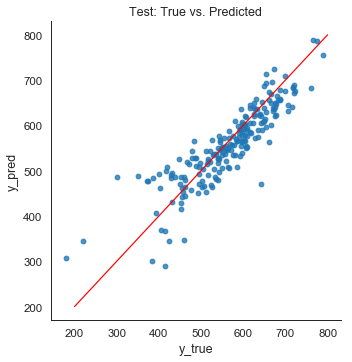

In [20]:
test_acc = pd.DataFrame()
test_acc['y_true'] = y_test_re[:,0]
test_acc['y_pred'] = test_predict[:,0]

#fig, ax = plt.subplots(figsize=(6,6))
x = np.linspace(200,800,1000)
ax = sns.lmplot(x='y_true', y='y_pred', data=test_acc, fit_reg=False)
ax = sns.lineplot(x=x,y=x, color='red')
plt.title('Test: True vs. Predicted')

The results of this LSTM model show that demographic variables and the reading score in one grade predict the reading score in the subsequent grade with 77.0% accuracy. Results will of course vary depending on the train-test split. 

But, we don't know which predictor variables contributed to this accuracy level, nor does the model demonstrate the efficacy of the universal newborn hearing screening program. 

The Linear Regression example shows the breakdown of how different predictors contribute to reading scores.

The Visualization example shows how reading scores change over time.